<a href="https://colab.research.google.com/github/Jules-gatete/RxMediq_Summative-assignment---MLOP/blob/main/RxMediq_Model_Jules_Gatete_assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORTING LIBRARIES


In [26]:
# Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping
import joblib

#Set random seed for reproducibility


In [27]:
# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

#Load dataset


In [28]:
# Load dataset
file_path = "/content/Drug prescription Dataset.csv"

df = pd.read_csv(file_path)

print("\n✓ Dataset loaded successfully from:", file_path)


✓ Dataset loaded successfully from: /content/Drug prescription Dataset.csv


#DATA EXPLORATION


In [29]:
def explore_data(df):
    """Display basic information and statistics about the dataset."""
    print("\n=== Dataset Preview ===")
    print(df.head())
    print("\n=== Dataset Info ===")
    print(df.info())
    print("\n=== Dataset Statistics ===")
    print(df.describe())
    print("\n=== Missing Values ===")
    print(df.isnull().sum())

#DATA VISUALIZATION


In [30]:
def visualize_data(df):
    """Generate visualizations to understand data distributions."""
    # Age Distribution
    plt.figure(figsize=(8,5))
    sns.histplot(df["age"], bins=20, kde=True, color="blue")
    plt.title("Age Distribution")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.show()
    print("Story: Age distribution highlights patient age range, suggesting age-specific drug trends.")

    # Drug Distribution
    plt.figure(figsize=(8,4))
    sns.countplot(x="drug", data=df, palette="viridis")
    plt.title("Class Distribution of Drugs")
    plt.xticks(rotation=45)
    plt.show()
    print("Story: Drug distribution shows prescription frequency, indicating common treatments.")

    # Severity vs. Drug
    plt.figure(figsize=(10,6))
    sns.countplot(x="severity", hue="drug", data=df, palette="viridis")
    plt.title("Severity vs. Drug Prescription")
    plt.xticks(rotation=45)
    plt.show()
    print("Story: Severity influences drug choice, with distinct preferences per level.")

    # Correlation Heatmap (numeric columns only)
    numeric_df = df.select_dtypes(include=np.number)
    corr_matrix = numeric_df.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title("Correlation Heatmap (Numeric Columns)")
    plt.show()
    print("Story: Correlation heatmap shows relationships between numeric features.")

#DATA PREPROCESSING FUNCTIONS


In [31]:
def preprocess_data(df):
    """Preprocesses the dataset."""
    # Define features and target
    X = df.drop('drug', axis=1)  # Assuming 'drug' is the target variable
    y = df['drug']

    # Label Encoding for Categorical Features
    label_encoders = {}
    categorical_cols = ["disease", "gender", "severity"]
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col])
        label_encoders[col] = le

    # Encode target variable
    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)

    # Feature Scaling for Numerical Features
    scaler = StandardScaler()
    numerical_cols = ["age"]
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    return X, y_encoded, label_encoders, scaler, target_encoder



=== Dataset Preview ===
    disease  age gender severity                drug
0  diarrhea    4   male      LOW  promegranate drink
1  diarrhea    4   male   NORMAL          lime juice
2  diarrhea    5   male      LOW  promegranate drink
3  diarrhea    5   male   NORMAL          lime juice
4  diarrhea    6   male      LOW  promegranate drink

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   disease   1288 non-null   object
 1   age       1288 non-null   int64 
 2   gender    1288 non-null   object
 3   severity  1288 non-null   object
 4   drug      1288 non-null   object
dtypes: int64(1), object(4)
memory usage: 50.4+ KB
None

=== Dataset Statistics ===
               age
count  1288.000000
mean     33.645963
std      15.532570
min       4.000000
25%      20.000000
50%      34.000000
75%      47.000000
max      60.000000

=== Mis

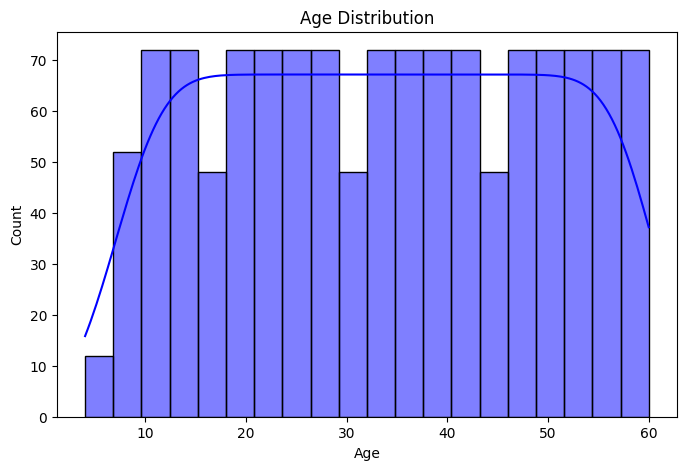

Story: Age distribution highlights patient age range, suggesting age-specific drug trends.


<ipython-input-30-048b44058939>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="drug", data=df, palette="viridis")


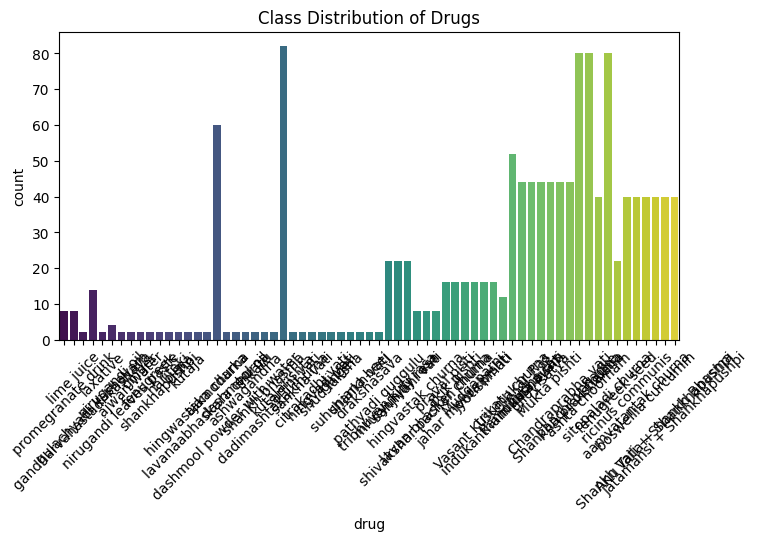

Story: Drug distribution shows prescription frequency, indicating common treatments.


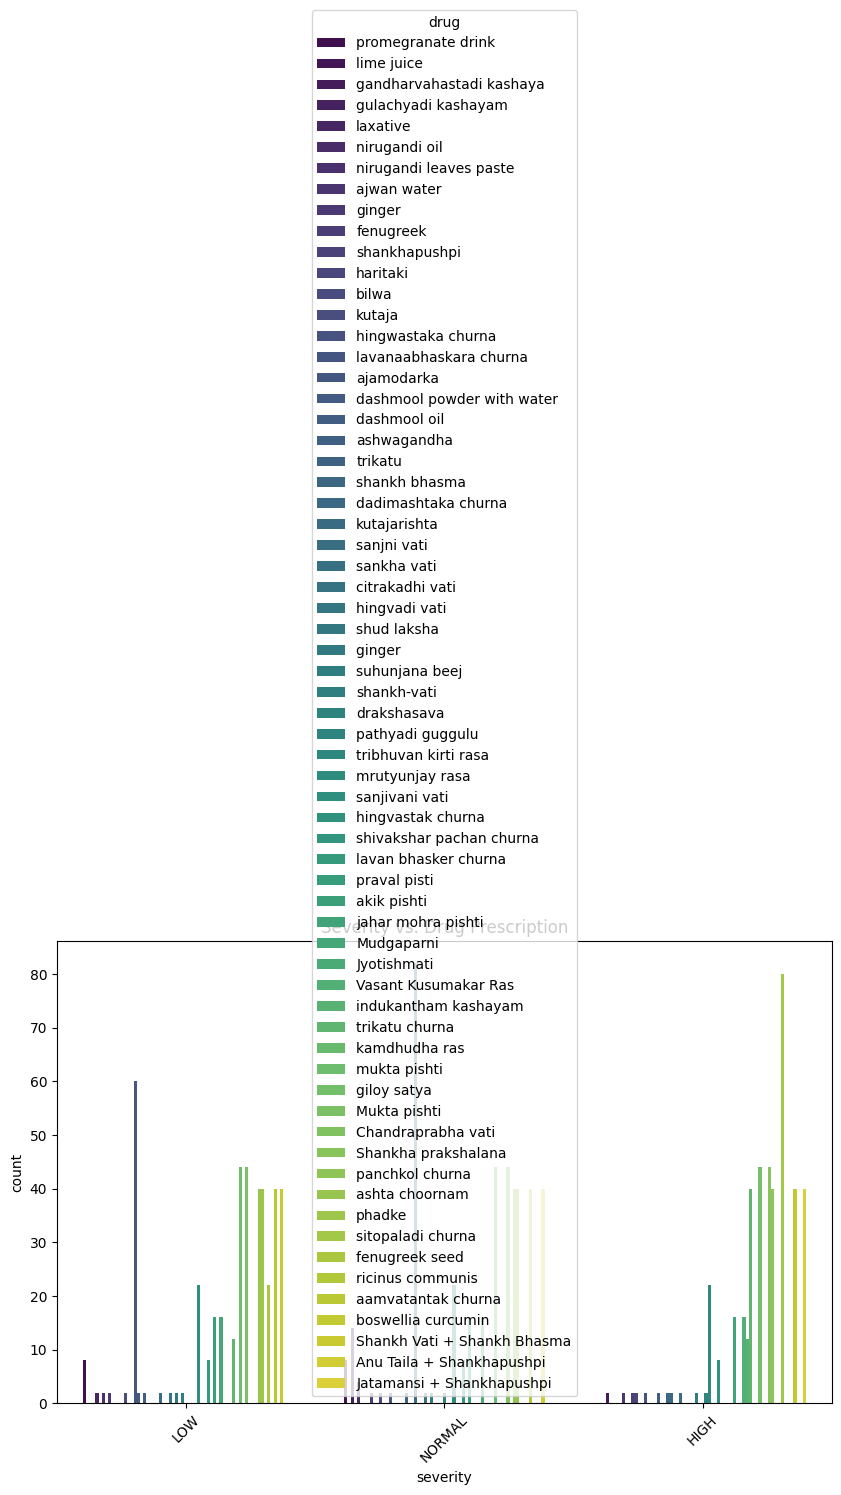

Story: Severity influences drug choice, with distinct preferences per level.


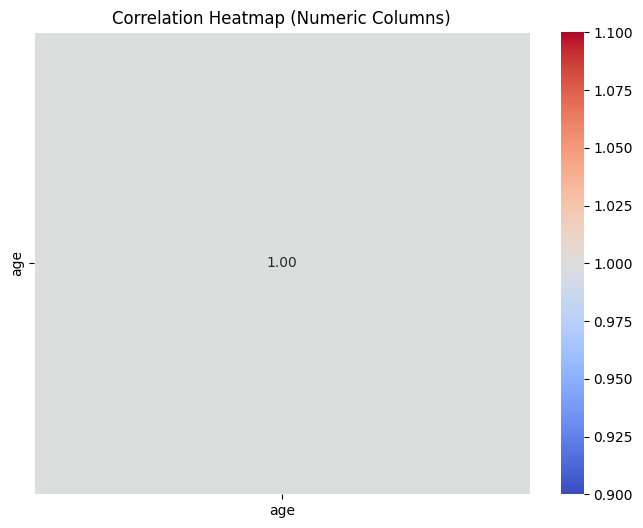

Story: Correlation heatmap shows relationships between numeric features.

 'dadimashtaka churna' 'dashmool oil' 'dashmool powder with water'
 'drakshasava' 'fenugreek' 'gandharvahastadi kashaya' 'ginger' 'ginger '
 'haritaki' 'hingvadi vati' 'hingwastaka churna' 'kutaja'
 'lavanaabhaskara churna' 'laxative' 'nirugandi leaves paste'
 'nirugandi oil' 'pathyadi guggulu' 'sanjni vati' 'sankha vati'
 'shankh bhasma' 'shankh-vati' 'shankhapushpi' 'shud laksha'
 'suhunjana beej' 'trikatu']
Proceeding with split without stratification for validation/test set.


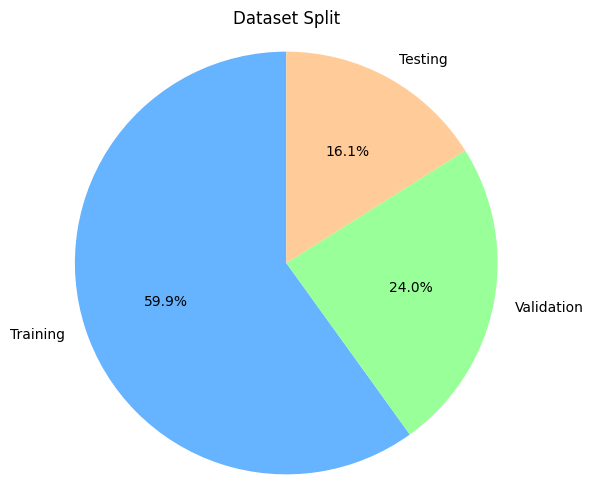

Training set size: 772
Validation set size: 309
Testing set size: 207


In [32]:
# Data exploration and visualization
explore_data(df)
visualize_data(df)

# Preprocess data
X, y, label_encoders, scaler, target_encoder = preprocess_data(df)

# First split: train and temporary set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# Check class distribution in y_temp
unique_classes, counts = np.unique(y_temp, return_counts=True)
rare_classes = unique_classes[counts < 2]
if len(rare_classes) > 0:
    print(f"\nWarning: Found {len(rare_classes)} classes with only 1 instance: {target_encoder.inverse_transform(rare_classes)}")
    print("Proceeding with split without stratification for validation/test set.")
    # Second split without stratification if rare classes exist
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42)
else:
    # Second split with stratification if no rare classes
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.40, random_state=42, stratify=y_temp)

# Visualize data split
train_size = X_train.shape[0]
val_size = X_val.shape[0]
test_size = X_test.shape[0]
labels = ['Training', 'Validation', 'Testing']
sizes = [train_size, val_size, test_size]
colors = ['#66b3ff', '#99ff99', '#ffcc99']

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Dataset Split')
plt.axis('equal')
plt.show()
print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Testing set size: {test_size}")

#MODEL TRAINING


In [33]:
def build_and_train_model(X_train, y_train, X_val, y_val, num_classes):
    """Build and train a neural network with optimization techniques."""
    model = Sequential([
        Dense(64, activation='relu', input_dim=X_train.shape[1]),
        BatchNormalization(),
        Dropout(0.2),
        Dense(48, activation='relu'),
        BatchNormalization(),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adagrad(learning_rate=0.01),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                       epochs=200,
                       batch_size=32,
                       validation_data=(X_val, y_val),
                       verbose=1,
                       callbacks=[EarlyStopping(monitor='val_loss',
                                              patience=20,
                                              restore_best_weights=True)])
    return model, history

#MODEL EVALUATION


In [38]:
def evaluate_model(model, X_test, y_test, model_name, history=None):
    """Evaluate the model using multiple metrics and visualizations."""
    # Compute loss and predictions
    loss = model.evaluate(X_test, y_test, verbose=0)[0]
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Calculate metrics
    metrics = {
        "Loss": loss,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    # Display metrics
    print(f"\n=== Performance Metrics - {model_name} ===")
    print(f"Loss: {metrics['Loss']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")

    # Plot training history
    if history:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"Training History - {model_name}")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()

    # Create heatmap for confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return metrics

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.0328 - loss: 4.1993 - val_accuracy: 0.0453 - val_loss: 4.0813
Epoch 2/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2003 - loss: 3.4359 - val_accuracy: 0.0680 - val_loss: 3.9494
Epoch 3/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3234 - loss: 3.0095 - val_accuracy: 0.1133 - val_loss: 3.7866
Epoch 4/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4054 - loss: 2.7444 - val_accuracy: 0.1812 - val_loss: 3.5954
Epoch 5/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4471 - loss: 2.4973 - val_accuracy: 0.2104 - val_loss: 3.3917
Epoch 6/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4672 - loss: 2.3231 - val_accuracy: 0.2589 - val_loss: 3.1702
Epoch 7/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5339 - loss: 2.1451 - val_accuracy: 0.2945 - val_loss: 2.9475
Epoch 8/200
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5881 - loss: 2.0073 - val_accuracy: 0.3592 - val_loss: 2.

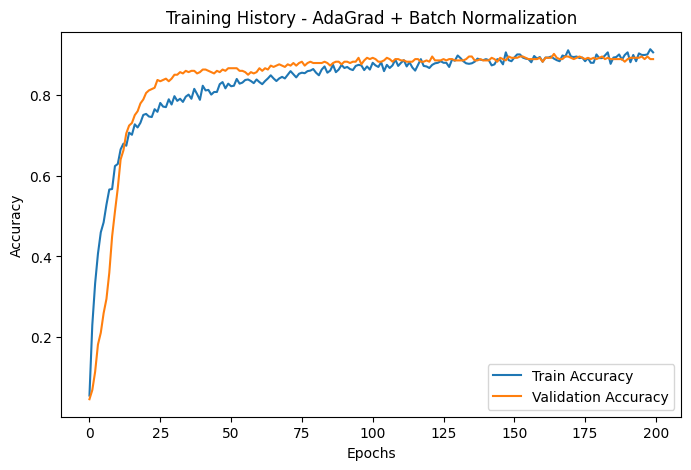

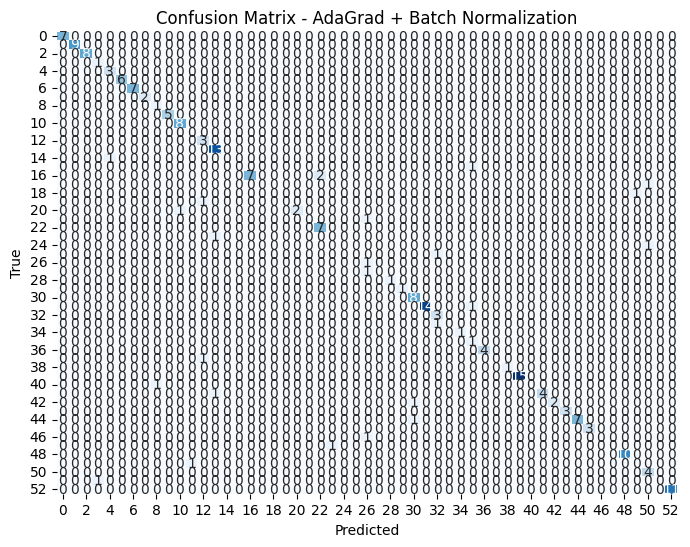

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
Predicted Labels: ['promegranate drink' 'lime juice' 'promegranate drink' 'lime juice'
 'promegranate drink']


In [39]:
num_classes = len(np.unique(y))
model, history = build_and_train_model(X_train, y_train, X_val, y_val, num_classes)
metrics = evaluate_model(model, X_test, y_test, "AdaGrad + Batch Normalization", history)

# Save model and preprocessors
import os

# Define file paths
model_path = 'drug_prescription_model.keras'
scaler_path = 'scaler.pkl'
target_enc_path = 'label_enc.pkl'
label_encoders_path = 'label_encoders.pkl'

# Save model (using Keras format, overwrite if exists)
model.save(model_path, overwrite=True)

# Save preprocessors (overwrite if exists)
joblib.dump(scaler, scaler_path)
joblib.dump(target_encoder, target_enc_path)
joblib.dump(label_encoders, label_encoders_path)

def load_model_and_predict(new_data):
    """Load saved model and make predictions on new data."""
    # Load model and preprocessors
    model = load_model(model_path)  # Updated to use .keras file
    scaler = joblib.load(scaler_path)
    label_encoders = joblib.load(label_encoders_path)
    target_encoder = joblib.load(target_enc_path)

    # Preprocess new data
    new_data_processed = new_data.copy()
    for col, le in label_encoders.items():
        if col in new_data_processed.columns:
            new_data_processed[col] = le.transform(new_data_processed[col])
        else:
            raise ValueError(f"Column '{col}' not found in new_data")
    new_data_processed[["age"]] = scaler.transform(new_data_processed[["age"]])

    # Make predictions
    predictions = model.predict(new_data_processed)
    predicted_classes = np.argmax(predictions, axis=1)
    predicted_labels = target_encoder.inverse_transform(predicted_classes)

    return predicted_labels

# Example usage
try:
    new_data = df.head(5).drop('drug', axis=1)
    predicted_labels = load_model_and_predict(new_data)
    print(f"Predicted Labels: {predicted_labels}")
except Exception as e:
    print(f"Error during prediction: {e}")